<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/3D_SEG_Salt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 16.6 MB/s eta 0:00:00


Using device: cuda
Phase 1: Generating Observed Data...
Phase 2: Starting Inversion...
Epoch 0 | Loss: 9.381376e-03


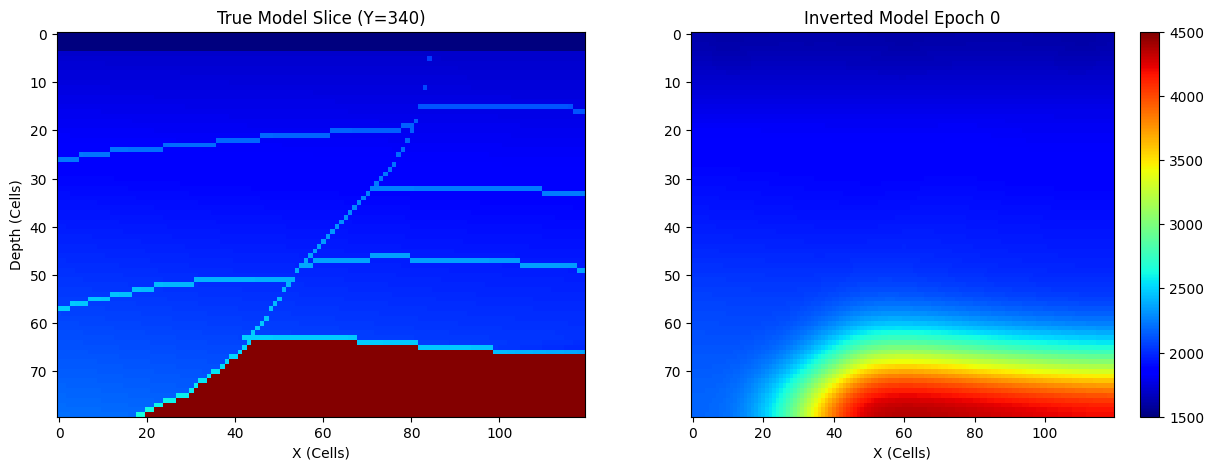

KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import os

# 1. DEVICE AND CONFIGURATION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Original Model Specifications
n1, n2, n3 = 210, 676, 676 # Depth, X, Y
h = 20.0 # meters (0.02 km)
vp_path = '3D_seg_salt'

# 2. LOAD AND RESHAPE (FORTRAN ORDER)
# This fixes the "stripy" appearance by correctly identifying Depth as the fast axis
v_true_flat = np.fromfile(vp_path, dtype=np.float32)
v_true_full = v_true_flat[:n1*n2*n3].reshape((n1, n2, n3), order='F')

# 3. SELECT A SUB-VOLUME THAT FITS IN 15GB RAM
# Reduced slightly further to ensure 100% stability on T4
# 80 * 120 * 120 = 1.15 million cells (vs 2.25M previously)
nz_crop, nx_crop, ny_crop = 80, 120, 120
z0, x0, y0 = 0, 260, 280

v_true = torch.from_numpy(v_true_full[z0:z0+nz_crop, x0:x0+nx_crop, y0:y0+ny_crop]).to(device)

# 4. ACQUISITION PARAMETERS
n_shots = 8 # Reduced shots to speed up loop
n_receivers_per_shot = 100 # 10x10 grid
freq = 4.5
pml_freq = freq
dt = 0.004  # Increased dt slightly
nt = 300    # Reduced nt to save memory (300 steps * 1.15M cells fits well in 15GB)
spacing = (h, h, h)
peak_time = 1.5 / freq

# Geometry Setup
source_loc = torch.zeros(n_shots, 1, 3, dtype=torch.long, device=device)
source_loc[..., 0] = 2
sx = torch.linspace(10, nx_crop-10, 3).long()
sy = torch.linspace(10, ny_crop-10, 3).long()
SX, SY = torch.meshgrid(sx, sy, indexing='ij')
source_loc[:, 0, 1] = SX.flatten()[:n_shots]
source_loc[:, 0, 2] = SY.flatten()[:n_shots]

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 3, dtype=torch.long, device=device)
receiver_loc[..., 0] = 2
rx = torch.linspace(0, nx_crop-1, 10).long()
ry = torch.linspace(0, ny_crop-1, 10).long()
RX, RY = torch.meshgrid(rx, ry, indexing='ij')
receiver_loc[:, :, 1] = RX.flatten()
receiver_loc[:, :, 2] = RY.flatten()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, 1, 1).to(device))

# 5. GENERATE OBSERVED DATA
print("Phase 1: Generating Observed Data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     pml_width=[10, 10, 10, 10, 10, 10],
                     pml_freq=pml_freq, accuracy=4)
        observed_data[i] = out[-1]

# Memory Cleanup: Move data to CPU so GPU is dedicated to Inversion
v_true_cpu = v_true.cpu()
observed_data_cpu = observed_data.cpu()
del v_true
del observed_data
torch.cuda.empty_cache()

# 6. INVERSION INITIALIZATION
v_init = 1.0 / gaussian_filter(1.0 / v_true_cpu.numpy(), sigma=7)
v1 = torch.from_numpy(v_init).to(device).requires_grad_(True)

optimizer = torch.optim.Adam([v1], lr=20.0)
loss_fn = torch.nn.MSELoss()
losses = []

def taper(x): return deepwave.common.cosine_taper_end(x, 15)

def plot_progress(epoch, v_inv):
    vi = v_inv.detach().cpu().numpy()
    mid = ny_crop // 2
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(v_true_cpu[:, :, mid], cmap='jet', aspect='auto', vmin=1500, vmax=4500)
    ax[0].set_title(f"True Model Slice (Y={y0 + mid})")
    ax[0].set_ylabel("Depth (Cells)"); ax[0].set_xlabel("X (Cells)")

    im = ax[1].imshow(vi[:, :, mid], cmap='jet', aspect='auto', vmin=1500, vmax=4500)
    ax[1].set_title(f"Inverted Model Epoch {epoch}")
    ax[1].set_xlabel("X (Cells)")
    plt.colorbar(im, ax=ax[1])
    plt.show()

# 7. INVERSION LOOP
n_epochs = 201
print("Phase 2: Starting Inversion...")

for epoch in range(n_epochs):
    optimizer.zero_grad()
    epoch_loss = 0

    # Process shots individually
    for i in range(n_shots):
        obs_shot = observed_data_cpu[i:i+1].to(device)

        # No extra keywords here to avoid TypeError
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          pml_width=[10, 10, 10, 10, 10, 10],
                          pml_freq=pml_freq, accuracy=4)

        loss = loss_fn(taper(out_pred[-1]), taper(obs_shot))
        loss = loss / n_shots
        loss.backward()
        epoch_loss += loss.item()

        # Immediate cleanup
        del obs_shot, out_pred

    # Gradient Post-processing
    with torch.no_grad():
        # Smoothing gradient is critical for salt models
        grad_smooth = gaussian_filter(v1.grad.cpu().numpy(), sigma=1.2)
        v1.grad.copy_(torch.from_numpy(grad_smooth).to(device))
        optimizer.step()
        v1.clamp_(min=1500, max=4500)

    losses.append(epoch_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss:.6e}")
        plot_progress(epoch, v1)
        torch.cuda.empty_cache()

# 8. FINAL CONVERGENCE
plt.figure(figsize=(8, 4))
plt.plot(losses, color='blue', lw=2)
plt.yscale('log')
plt.title("3D SEG Salt FWI Convergence")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.grid(True, which='both', ls='--')
plt.show()

Using device: cuda
Inversion Grid: 140z x 136x x 136y
Cell Count: 2.59 Million cells
Phase 1: Generating Observed Data...


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1500.0, and a grid cell spacing of 100.0, there are only 3.75.
  warnings.warn(


GPU memory cleared. Proceeding to Inversion...
Phase 2: Starting Inversion...


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1502.4930419921875, and a grid cell spacing of 100.0, there are only 3.76.
  warnings.warn(


Epoch 0 | Loss: 4.370387e-02


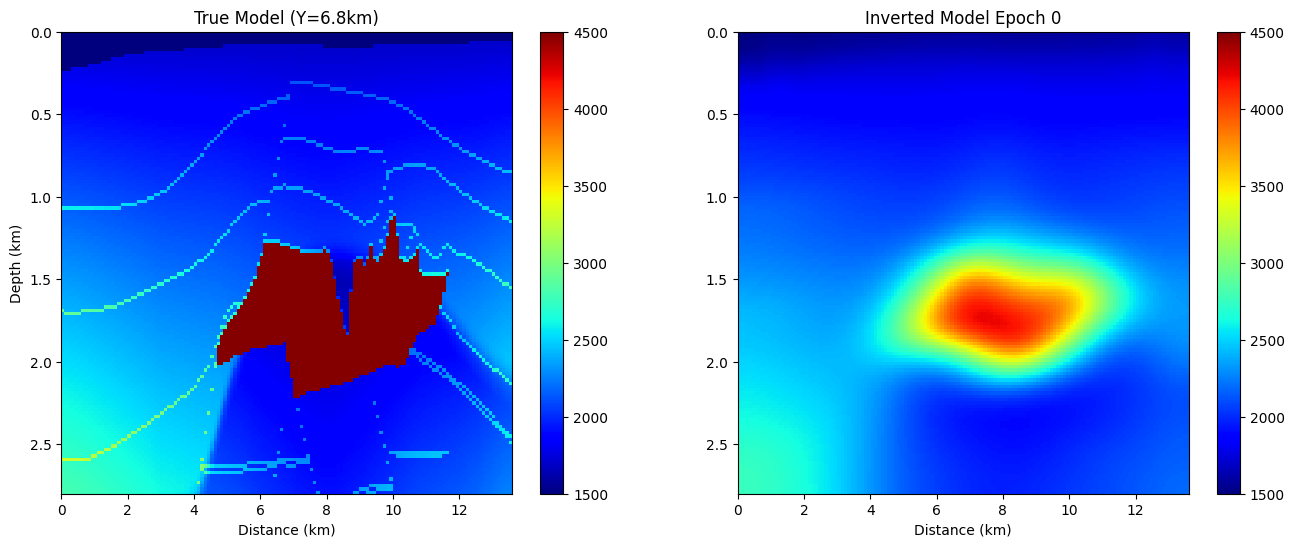

/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1500.581787109375, and a grid cell spacing of 100.0, there are only 3.75.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import os
import gc

# 0. CLEANUP PREVIOUS RUNS
torch.cuda.empty_cache()
gc.collect()

# 1. DEVICE AND CONFIGURATION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Original Model Specifications
n1, n2, n3 = 210, 676, 676 # Depth, X, Y
h_orig = 20.0 # meters
vp_path = '3D_seg_salt'

# 2. LOAD AND RESHAPE
v_true_flat = np.fromfile(vp_path, dtype=np.float32)
v_true_full = v_true_flat[:n1*n2*n3].reshape((n1, n2, n3), order='F')

# 3. DOWNSAMPLING & CROPPING (Optimized for 15GB T4)
# ds_factor=5 turns 676 into 135. 140x135x135 fits comfortably in 15GB.
ds_factor = 5
v_true_ds = v_true_full[:140, ::ds_factor, ::ds_factor]

nz, nx, ny = v_true_ds.shape
spacing = (h_orig, h_orig * ds_factor, h_orig * ds_factor)

# Move to GPU for data generation
v_true = torch.from_numpy(v_true_ds).to(device)

# 4. INITIAL MODEL
# Create the starting model by smoothing the true model
v_init_np = 1.0 / gaussian_filter(1.0 / v_true_ds, sigma=[5, 10, 10])
v1 = torch.from_numpy(v_init_np).to(device).requires_grad_(True)

print(f"Inversion Grid: {nz}z x {nx}x x {ny}y")
print(f"Cell Count: {nz*nx*ny/1e6:.2f} Million cells")

# 5. ACQUISITION GEOMETRY
n_shots = 9
n_receivers_per_shot = 100
freq = 4.0
dt = 0.004
nt = 250 # Reduced to 250 steps to ensure memory stability
peak_time = 1.5 / freq

# Sources
source_loc = torch.zeros(n_shots, 1, 3, dtype=torch.long, device=device)
source_loc[..., 0] = 2
sx = torch.linspace(10, nx-10, 3).long()
sy = torch.linspace(10, ny-10, 3).long()
SX, SY = torch.meshgrid(sx, sy, indexing='ij')
source_loc[:, 0, 1] = SX.flatten()[:n_shots]
source_loc[:, 0, 2] = SY.flatten()[:n_shots]

# Receivers
receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 3, dtype=torch.long, device=device)
receiver_loc[..., 0] = 2
rx = torch.linspace(0, nx-1, 10).long()
ry = torch.linspace(0, ny-1, 10).long()
RX, RY = torch.meshgrid(rx, ry, indexing='ij')
receiver_loc[:, :, 1] = RX.flatten()
receiver_loc[:, :, 2] = RY.flatten()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, 1, 1).to(device))

# 6. GENERATE OBSERVED DATA
print("Phase 1: Generating Observed Data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq)
        observed_data[i] = out[-1]

# CRITICAL MEMORY STEP: Clear the GPU of the True Model
v_true_cpu = v_true.cpu()
obs_cpu = observed_data.cpu()
del v_true, observed_data
torch.cuda.empty_cache()
gc.collect()
print("GPU memory cleared. Proceeding to Inversion...")

# 7. INVERSION SETUP
optimizer = torch.optim.Adam([v1], lr=25.0)
loss_fn = torch.nn.MSELoss()
losses = []

def taper(x): return deepwave.common.cosine_taper_end(x, 15)

def plot_progress(epoch, v_inv):
    vi = v_inv.detach().cpu().numpy()
    mid_y = ny // 2
    # Kilometers for the plot labels
    extent = [0, nx*spacing[1]/1000, nz*h_orig/1000, 0]

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    im1 = ax[0].imshow(v_true_cpu[:, :, mid_y], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent)
    ax[0].set_title(f"True Model (Y={mid_y*spacing[2]/1000:.1f}km)")
    ax[0].set_ylabel("Depth (km)"); ax[0].set_xlabel("Distance (km)")

    im2 = ax[1].imshow(vi[:, :, mid_y], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent)
    ax[1].set_title(f"Inverted Model Epoch {epoch}")
    ax[1].set_xlabel("Distance (km)")

    plt.colorbar(im1, ax=ax[0]); plt.colorbar(im2, ax=ax[1])
    plt.show()

# 8. INVERSION LOOP
n_epochs = 151
print("Phase 2: Starting Inversion...")

for epoch in range(n_epochs):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        # Transfer only the current shot to GPU
        obs_shot = obs_cpu[i:i+1].to(device)

        # accuracy=2 saves a small amount of memory compared to accuracy=4
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq,
                          accuracy=2)

        loss = loss_fn(taper(out_pred[-1]), taper(obs_shot))
        loss = loss / n_shots
        loss.backward()
        epoch_loss += loss.item()

        # Explicitly delete shot-specific tensors to prevent accumulation
        del obs_shot, out_pred
        # torch.cuda.empty_cache() # Uncomment if OOM still occurs here

    # Gradient Post-processing
    with torch.no_grad():
        grad_np = v1.grad.cpu().numpy()
        grad_smooth = gaussian_filter(grad_np, sigma=1.5)
        v1.grad.copy_(torch.from_numpy(grad_smooth).to(device))
        optimizer.step()
        v1.clamp_(min=1500, max=4500)

    losses.append(epoch_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss:.6e}")
        plot_progress(epoch, v1)
        torch.cuda.empty_cache()

# 9. CONVERGENCE
plt.figure(figsize=(8, 4))
plt.plot(losses); plt.yscale('log'); plt.title("FWI Convergence"); plt.show()

Using device: cuda
Inversion Grid: 180z (Depth) x 169x x 169y
Slice Indices for Plots: Y_index=84, Z_index=100
Phase 1: Generating Observed Data...
Phase 2: Starting Inversion...
Epoch 0 | Loss: 3.308779e-02


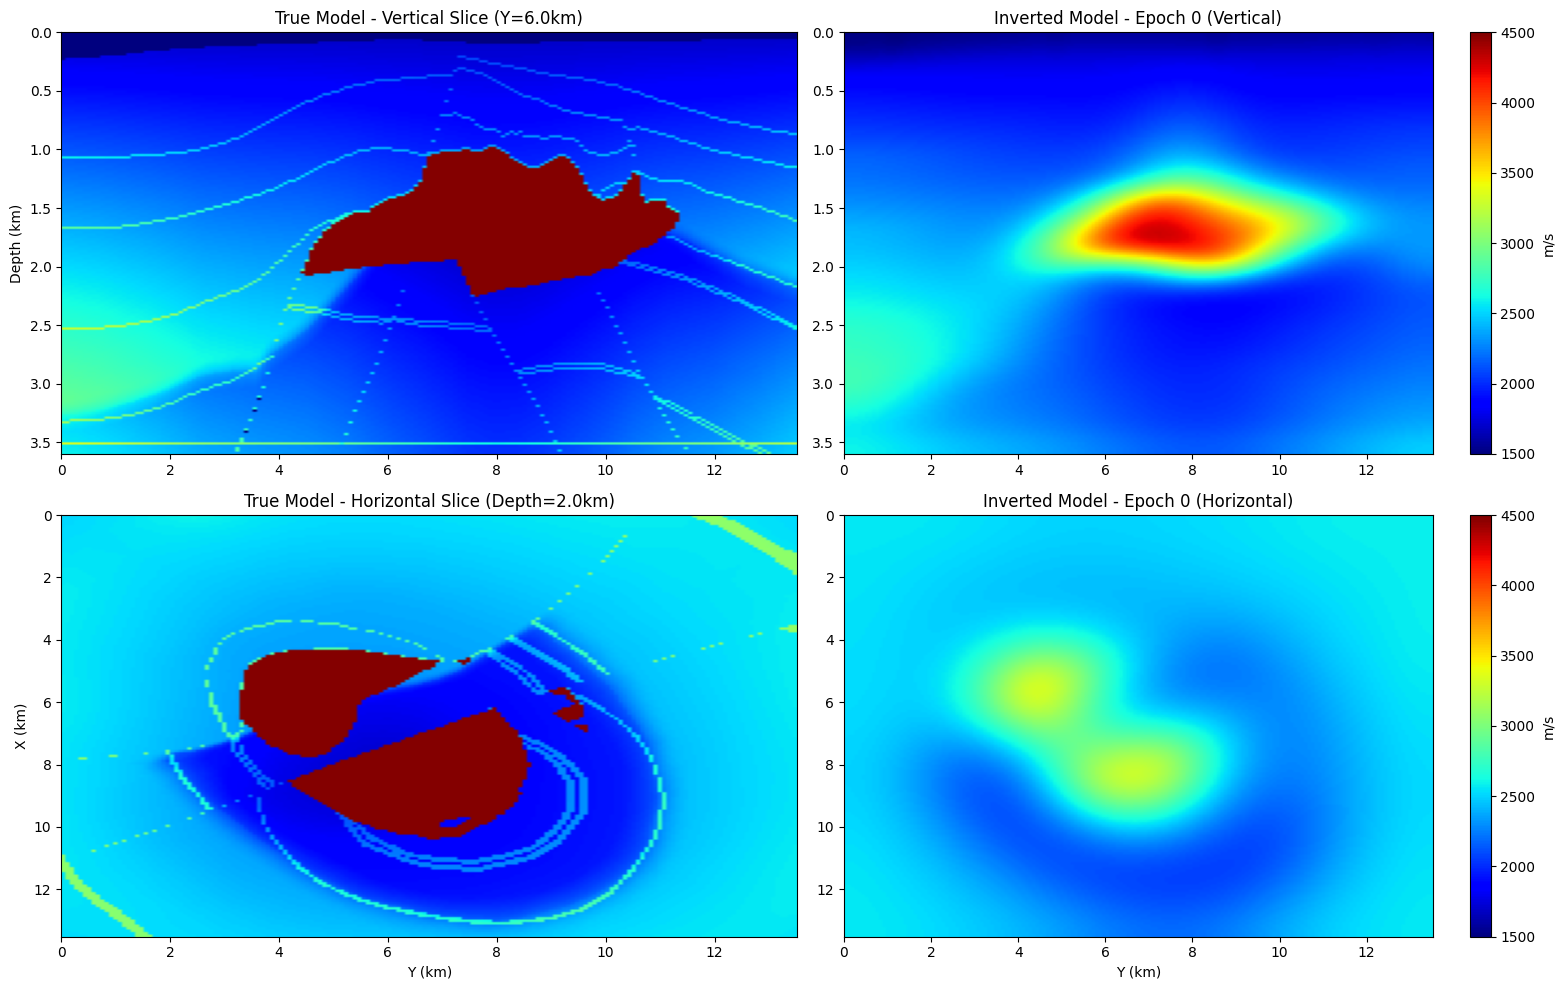

Epoch 50 | Loss: 6.511819e-05


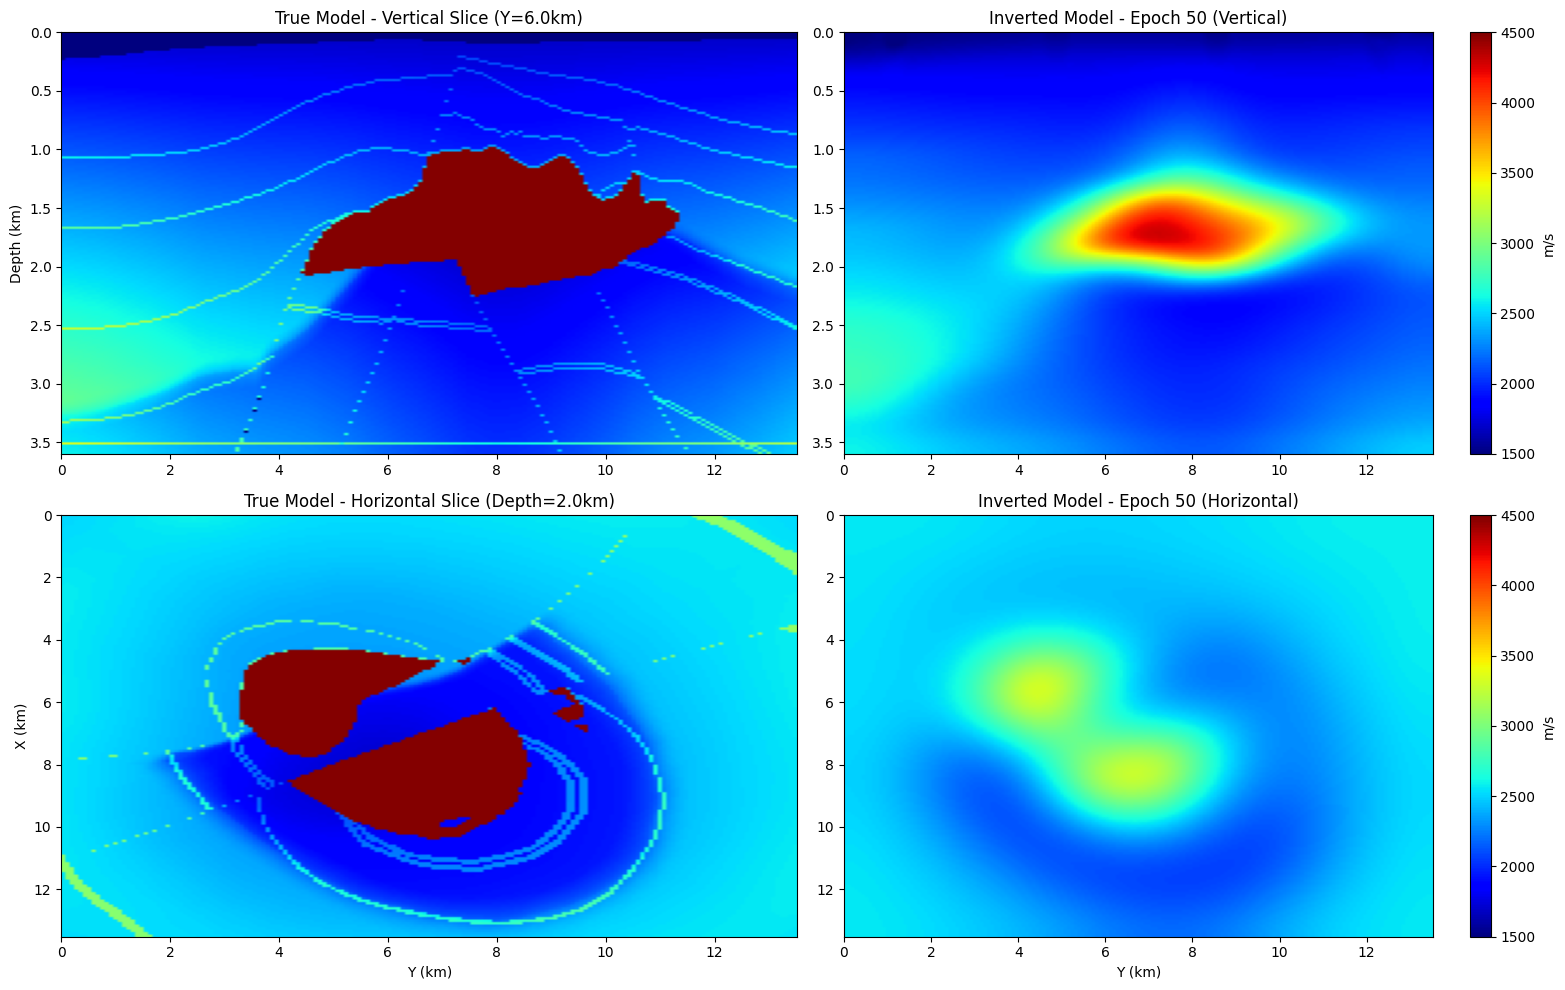

In [ ]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import os
import gc

# 0. MEMORY OPTIMIZATION
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()
gc.collect()

# 1. DEVICE AND CONFIGURATION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Original Model Specifications from your script
n1, n2, n3 = 210, 676, 676  # Depth, X, Y
h_orig = 0.02               # 0.02 km = 20 meters
vp_path = '3D_seg_salt'

# 2. LOAD AND RESHAPE (FORTRAN ORDER)
# This orientation is critical to match the reference images
v_true_flat = np.fromfile(vp_path, dtype=np.float32)
v_true_full = v_true_flat[:n1*n2*n3].reshape((n1, n2, n3), order='F')

# 3. GLOBAL DOWNSAMPLING (To see the whole structure within 15GB)
# Downsample X and Y by 4, and Depth slightly to fit T4 memory
ds_factor = 4
v_true_ds = v_true_full[:180, ::ds_factor, ::ds_factor]

nz, nx, ny = v_true_ds.shape
spacing = (h_orig * 1000, h_orig * ds_factor * 1000, h_orig * ds_factor * 1000) # In meters

# Move to GPU for data generation
v_true = torch.from_numpy(v_true_ds).to(device)

# 4. INITIAL MODEL
# Create a smooth starting model
v_init_np = 1.0 / gaussian_filter(1.0 / v_true_ds, sigma=[5, 12, 12])
v1 = torch.from_numpy(v_init_np).to(device).requires_grad_(True)

print(f"Inversion Grid: {nz}z (Depth) x {nx}x x {ny}y")
print(f"Slice Indices for Plots: Y_index={ny//2}, Z_index={100}")

# 5. ACQUISITION GEOMETRY
n_shots = 12
n_receivers_per_shot = 144 # 12x12 grid
freq = 4.0
dt = 0.004
nt = 250 # Reduced to 250 steps to ensure memory stability
peak_time = 1.5 / freq

# Sources distributed across the surface
source_loc = torch.zeros(n_shots, 1, 3, dtype=torch.long, device=device)
source_loc[..., 0] = 2
sx = torch.linspace(10, nx-10, 4).long()
sy = torch.linspace(10, ny-10, 3).long()
SX, SY = torch.meshgrid(sx, sy, indexing='ij')
source_loc[:, 0, 1] = SX.flatten()[:n_shots]
source_loc[:, 0, 2] = SY.flatten()[:n_shots]

# Receivers (Surface grid)
receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 3, dtype=torch.long, device=device)
receiver_loc[..., 0] = 2
rx = torch.linspace(0, nx-1, 12).long()
ry = torch.linspace(0, ny-1, 12).long()
RX, RY = torch.meshgrid(rx, ry, indexing='ij')
receiver_loc[:, :, 1] = RX.flatten()
receiver_loc[:, :, 2] = RY.flatten()

source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
              .repeat(n_shots, 1, 1).to(device))

# 6. GENERATE OBSERVED DATA
print("Phase 1: Generating Observed Data...")
observed_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
with torch.no_grad():
    for i in range(n_shots):
        out = scalar(v_true, spacing, dt,
                     source_amplitudes=source_amp[i:i+1],
                     source_locations=source_loc[i:i+1],
                     receiver_locations=receiver_loc[i:i+1],
                     pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq, accuracy=2)
        observed_data[i] = out[-1]

# Clear GPU memory for the Inversion phase
v_true_cpu = v_true.cpu()
obs_cpu = observed_data.cpu()
del v_true, observed_data
torch.cuda.empty_cache()
gc.collect()

# 7. INVERSION TOOLS
optimizer = torch.optim.Adam([v1], lr=20.0)
loss_fn = torch.nn.MSELoss()
losses = []

def taper(x): return deepwave.common.cosine_taper_end(x, 15)

# 8. THE DUAL-SLICE VISUALIZATION FUNCTION
def plot_progress(epoch, v_inv):
    vi = v_inv.detach().cpu().numpy()
    vt = v_true_cpu.numpy()

    # Slices selection (Matching your reference: Y=6km and Z=2km)
    iy = int(6.0 / (h_orig * ds_factor)) # Y index approx 6km
    iz = int(2.0 / h_orig)               # Z index approx 2km

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ROW 1: VERTICAL SLICES (Depth vs Distance)
    extent_v = [0, nx*spacing[1]/1000, nz*h_orig, 0]
    im0 = axes[0,0].imshow(vt[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,0].set_title(f"True Model - Vertical Slice (Y=6.0km)")
    axes[0,0].set_ylabel("Depth (km)")

    im1 = axes[0,1].imshow(vi[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,1].set_title(f"Inverted Model - Epoch {epoch} (Vertical)")
    plt.colorbar(im1, ax=axes[0,1], label="m/s")

    # ROW 2: HORIZONTAL SLICES (X vs Y)
    extent_h = [0, ny*spacing[2]/1000, nx*spacing[1]/1000, 0]
    im2 = axes[1,0].imshow(vt[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,0].set_title(f"True Model - Horizontal Slice (Depth=2.0km)")
    axes[1,0].set_ylabel("X (km)"); axes[1,0].set_xlabel("Y (km)")

    im3 = axes[1,1].imshow(vi[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,1].set_title(f"Inverted Model - Epoch {epoch} (Horizontal)")
    axes[1,1].set_xlabel("Y (km)")
    plt.colorbar(im3, ax=axes[1,1], label="m/s")

    plt.tight_layout()
    plt.show()

# 9. INVERSION LOOP
n_epochs = 201
print("Phase 2: Starting Inversion...")

for epoch in range(n_epochs):
    optimizer.zero_grad()
    epoch_loss = 0

    for i in range(n_shots):
        obs_shot = obs_cpu[i:i+1].to(device)
        out_pred = scalar(v1, spacing, dt,
                          source_amplitudes=source_amp[i:i+1],
                          source_locations=source_loc[i:i+1],
                          receiver_locations=receiver_loc[i:i+1],
                          pml_width=[8, 8, 8, 8, 8, 8], pml_freq=freq, accuracy=2)

        loss = loss_fn(taper(out_pred[-1]), taper(obs_shot))
        loss = loss / n_shots
        loss.backward()
        epoch_loss += loss.item()
        del obs_shot, out_pred

    # Gradient Post-processing
    with torch.no_grad():
        grad_np = v1.grad.cpu().numpy()
        grad_smooth = gaussian_filter(grad_np, sigma=1.5)
        v1.grad.copy_(torch.from_numpy(grad_smooth).to(device))
        optimizer.step()
        v1.clamp_(min=1500, max=4500)

    losses.append(epoch_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss:.6e}")
        plot_progress(epoch, v1)
        torch.cuda.empty_cache()
        gc.collect()

# 10. CONVERGENCE PLOT
plt.figure(figsize=(8, 4))
plt.plot(losses, color='red', lw=2)
plt.yscale('log')
plt.title("FWI Convergence (3D SEG Salt)")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.grid(True, which='both', ls='--')
plt.show()

## multiscale

In [3]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import os
import gc

# 0. SYSTEM SETUP
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Original Model Specifications
n1, n2, n3 = 210, 676, 676  # Depth, X, Y
h_orig = 0.02               # 20 meters
vp_path = '3D_seg_salt'

# 1. LOAD AND PREPARE DATA (Fortran Order)
v_true_flat = np.fromfile(vp_path, dtype=np.float32)
v_true_full = v_true_flat[:n1*n2*n3].reshape((n1, n2, n3), order='F')

# 2. DOWNSAMPLING (Balancing Sharpness vs Memory)
# Factor of 4 provides enough resolution to see salt boundaries clearly
ds_factor = 4
v_true_ds = v_true_full[:160, ::ds_factor, ::ds_factor]
nz, nx, ny = v_true_ds.shape
spacing = (h_orig * 1000, h_orig * ds_factor * 1000, h_orig * ds_factor * 1000)

# Move to CPU to save GPU RAM for inversion
v_true_cpu = torch.from_numpy(v_true_ds)

# 3. INITIAL MODEL (Starting point for FWI)
v_init_np = 1.0 / gaussian_filter(1.0 / v_true_ds, sigma=[5, 12, 12])
v1 = torch.from_numpy(v_init_np).to(device).requires_grad_(True)

# 4. ACQUISITION SETUP
n_shots = 12
n_receivers_per_shot = 144 # 12x12 grid
dt = 0.0035
nt = 350
# Kilometers for Plotting
extent_v = [0, nx*spacing[1]/1000, nz*h_orig, 0]
extent_h = [0, ny*spacing[2]/1000, nx*spacing[1]/1000, 0]

# Sources & Receivers
source_loc = torch.zeros(n_shots, 1, 3, dtype=torch.long, device=device)
source_loc[..., 0] = 2
sx = torch.linspace(10, nx-10, 4).long(); sy = torch.linspace(10, ny-10, 3).long()
SX, SY = torch.meshgrid(sx, sy, indexing='ij')
source_loc[:, 0, 1] = SX.flatten()[:n_shots]; source_loc[:, 0, 2] = SY.flatten()[:n_shots]

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 3, dtype=torch.long, device=device)
receiver_loc[..., 0] = 2
rx = torch.linspace(0, nx-1, 12).long(); ry = torch.linspace(0, ny-1, 12).long()
RX, RY = torch.meshgrid(rx, ry, indexing='ij')
receiver_loc[:, :, 1] = RX.flatten()[:n_receivers_per_shot]
receiver_loc[:, :, 2] = RY.flatten()[:n_receivers_per_shot]

# 5. VISUALIZATION FUNCTION
def plot_progress(epoch, v_inv, freq_name):
    vi = v_inv.detach().cpu().numpy()
    vt = v_true_cpu.numpy()
    iy, iz = ny // 2, 100 # Slices at Y=mid and Depth approx 2km

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    # Vertical Slices
    axes[0,0].imshow(vt[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,0].set_title("True Model (Vertical Slice)")
    im1 = axes[0,1].imshow(vi[:, :, iy], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_v)
    axes[0,1].set_title(f"Inverted Epoch {epoch} ({freq_name})")
    plt.colorbar(im1, ax=axes[0,1], label="m/s")
    # Horizontal Slices
    axes[1,0].imshow(vt[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,0].set_title("True Model (Horizontal Slice Depth=2km)")
    im3 = axes[1,1].imshow(vi[iz, :, :], cmap='jet', aspect='auto', vmin=1500, vmax=4500, extent=extent_h)
    axes[1,1].set_title(f"Inverted Epoch {epoch} ({freq_name})")
    plt.colorbar(im3, ax=axes[1,1], label="m/s")
    plt.tight_layout(); plt.show()

def taper(x): return deepwave.common.cosine_taper_end(x, 15)

# 6. MULTI-SCALE INVERSION LOOP
# We start at 3.0Hz (Shape) and move to 5.5Hz (Edges)
freq_bands = [3.0, 5.5]
epochs_per_band = 50
optimizer = torch.optim.Adam([v1], lr=15.0)
loss_fn = torch.nn.MSELoss()
losses = []

print("Starting Multi-scale Inversion...")

for freq in freq_bands:
    print(f"\n>>> CURRENT FREQUENCY: {freq} Hz")
    peak_time = 1.5 / freq
    source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
                  .repeat(n_shots, 1, 1).to(device))

    # 6a. Generate Data for current Frequency Band
    with torch.no_grad():
        v_true_gpu = v_true_cpu.to(device)
        obs_data_freq = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
        for i in range(n_shots):
            out = scalar(v_true_gpu, spacing, dt, source_amplitudes=source_amp[i:i+1],
                         source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                         pml_width=[8,8,8,8,8,8], pml_freq=freq)
            obs_data_freq[i] = out[-1]
        v_true_gpu = v_true_gpu.cpu() # Clear from GPU
        obs_data_cpu = obs_data_freq.cpu()
        del obs_data_freq
        torch.cuda.empty_cache()

    # 6b. Inversion for this band
    for epoch in range(epochs_per_band):
        optimizer.zero_grad()
        epoch_loss = 0
        for i in range(n_shots):
            obs_shot = obs_data_cpu[i:i+1].to(device)
            out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                              source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                              pml_width=[8,8,8,8,8,8], pml_freq=freq, accuracy=2)

            loss = loss_fn(taper(out_pred[-1]), taper(obs_shot))
            loss = loss / n_shots
            loss.backward()
            epoch_loss += loss.item()
            del obs_shot, out_pred

        # Gradient Smoothing (reduces as freq increases to allow sharpness)
        with torch.no_grad():
            sigma_grad = 1.5 if freq < 4 else 0.8
            grad_smooth = gaussian_filter(v1.grad.cpu().numpy(), sigma=sigma_grad)
            v1.grad.copy_(torch.from_numpy(grad_smooth).to(device))
            optimizer.step()
            v1.clamp_(min=1500, max=4500)

        losses.append(epoch_loss)
        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch+1} | Loss: {epoch_loss:.6e}")
            plot_progress(len(losses), v1, f"{freq}Hz")
            torch.cuda.empty_cache()

# 7. FINAL RESULTS
plt.figure(figsize=(8, 4))
plt.plot(losses); plt.yscale('log'); plt.title("Multi-scale Convergence"); plt.show()

Using device: cuda


ValueError: cannot reshape array of size 31981568 into shape (210,676,676)